In [ ]:
import open3d as o3d
import numpy as np  
import matplotlib.pyplot as plt

pcd = o3d.io.read_point_cloud("Stella_xtion_1.pcd")

<class 'open3d.cpu.pybind.geometry.PointCloud'>
Precompute neighbors.[========================================] 100%
Cluster labels: [-1  0 -1 ... -1  9 -1]            ] 37%
Number of clusters: 54


In [13]:
pcd = o3d.io.read_point_cloud("stella_template.pcd")
o3d.visualization.draw_geometries([pcd])

In [ ]:
pcd = pcd.TetraMesh

In [ ]:
o3d.visualization.draw_geometries([pcd])

In [13]:
import open3d as o3d
import numpy as np

pcdt = o3d.io.read_point_cloud("stella_template.pcd")

pcd = o3d.io.read_point_cloud("Stella_1.pcd")
pcd.estimate_normals()
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
bbox = pcd.get_axis_aligned_bounding_box()
mesh = mesh.crop(bbox)

N = len(pcdt.points)
resampled = mesh.sample_points_poisson_disk(number_of_points=N)

o3d.visualization.draw_geometries([resampled])
o3d.io.write_point_cloud("resampled.pcd", resampled)


Jupyter environment detected. Enabling Open3D WebVisualizer.


AttributeError: partially initialized module 'open3d' has no attribute 'visualization' (most likely due to a circular import)

In [8]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

def preprocess_pcd(pcd, voxel_size):
    """Downsample + estimate normals + compute FPFH."""
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30)
    )
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=100)
    )
    return pcd_down, fpfh

def center_cloud(pcd):
    """Translate cloud so its centroid is at the origin."""
    pts = np.asarray(pcd.points)
    centroid = pts.mean(axis=0)
    pts -= centroid
    pcd.points = o3d.utility.Vector3dVector(pts)
    return pcd


def pca_align(pcd):
    """Rotate cloud using PCA so major axes align with XYZ."""
    pts = np.asarray(pcd.points)
    centroid = pts.mean(axis=0)
    pts_centered = pts - centroid

    H = pts_centered.T @ pts_centered
    eigvals, eigvecs = np.linalg.eigh(H)

    # sort eigenvectors by eigenvalue (largest first)
    R = eigvecs[:, ::-1]

    pts_rot = pts_centered @ R
    aligned = o3d.geometry.PointCloud()
    aligned.points = o3d.utility.Vector3dVector(pts_rot)

    return aligned, R

IMAGE = "Stella_xtion_1.png"
voxel_size = 0.01   # 1 cm
depth_image = o3d.io.read_image(IMAGE)

intrinsic = o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault
)

pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_image, intrinsic)

# Load YOLO bounding box
txt_file = IMAGE.rsplit(".", 1)[0] + ".txt"
cls_id, xc, yc, w, h = map(float, open(txt_file).read().split())

# --- Get image width/height ---
img_np = np.asarray(depth_image)
H, W = img_np.shape[:2]     # <-- Works on every Open3D version

# Convert YOLO → pixel coords
xmin = int((xc - w/2) * W)
xmax = int((xc + w/2) * W)
ymin = int((yc - h/2) * H)
ymax = int((yc + h/2) * H)

# --- Project point cloud to image ---
points = np.asarray(pcd.points)

X, Y, Z = points[:,0], points[:,1], points[:,2]

fx, fy = intrinsic.intrinsic_matrix[0,0], intrinsic.intrinsic_matrix[1,1]
cx, cy = intrinsic.intrinsic_matrix[0,2], intrinsic.intrinsic_matrix[1,2]

u = (X * fx / Z) + cx
v = (Y * fy / Z) + cy

# Mask
mask = (Z > 0) & \
       (u >= xmin) & (u <= xmax) & \
       (v >= ymin) & (v <= ymax)

cropped_points = points[mask]

cropped = o3d.geometry.PointCloud()
cropped.points = o3d.utility.Vector3dVector(cropped_points)

# o3d.visualization.draw_geometries([cropped])
pcd = cropped

labels = np.array(
    pcd.cluster_dbscan(eps=2.00, min_points=500, print_progress=True)
)

print("Cluster labels:", labels)
print("Number of clusters:", len(set(labels)) - (1 if -1 in labels else 0))

# --- Color each cluster ---
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = [0, 0, 0, 1]  # noise points colored black

pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])  # keep RGB only


template = o3d.io.read_point_cloud("stella_template.pcd")   # reference model
# Extract the points corresponding to a specific cluster label
cluster_label = 0  # Specify the cluster label you want to extract
cluster_points = np.asarray(pcd.points)[labels == cluster_label]

# Create a new point cloud for the selected cluster
cluster = o3d.geometry.PointCloud()
cluster.points = o3d.utility.Vector3dVector(cluster_points)

o3d.visualization.draw_geometries([template, cluster])

template = center_cloud(template)
cluster  = center_cloud(cluster)

template_aligned, R_t = pca_align(template)
cluster_aligned,  R_c = pca_align(cluster)

template.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=50)
)
cluster.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=50)
)

# Preprocess the template point cloud
template_down, template_fpfh = preprocess_pcd(template, voxel_size)
cluster_down, cluster_fpfh   = preprocess_pcd(cluster, voxel_size)

distance_threshold = voxel_size * 1.5

result_ransac = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    template_down, cluster_down,
    template_fpfh, cluster_fpfh,
    mutual_filter=True,
    max_correspondence_distance=distance_threshold,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
    ransac_n=4,
    checkers=[
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9)
    ],
    criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(
        max_iteration=400000,
        confidence=0.999
    )
)

print(result_ransac)

result_icp = o3d.pipelines.registration.registration_icp(
    template, cluster,
    max_correspondence_distance=voxel_size * 1.0,
    init=result_ransac.transformation,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane()
)

print(result_icp)
T = result_icp.transformation

template_transformed = template.transform(T)

template_col = template_transformed.paint_uniform_color([1, 0, 0])  # red
cluster_col  = cluster.paint_uniform_color([0, 1, 0])               # green

o3d.visualization.draw_geometries([template_col, cluster_col])
print("Cluster size:", len(cluster.points))
print("Template bounds:", template.get_max_bound() - template.get_min_bound())
print("Cluster bounds:", cluster.get_max_bound() - cluster.get_min_bound())



Cluster labels: [-1 -1 -1 ...  0  0  0]                       ] 2%
Number of clusters: 1
Precompute neighbors.[========================================] 100%
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Cluster size: 3796
Template bounds: [        3.3         5.7         3.3]
Cluster bounds: [     3.1627      5.9289       3.228]



image 1/1 /home/gustavo/3d-template-matching/Stella_right_1.png: 480x640 1 vase, 66.6ms
Speed: 2.1ms preprocess, 66.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


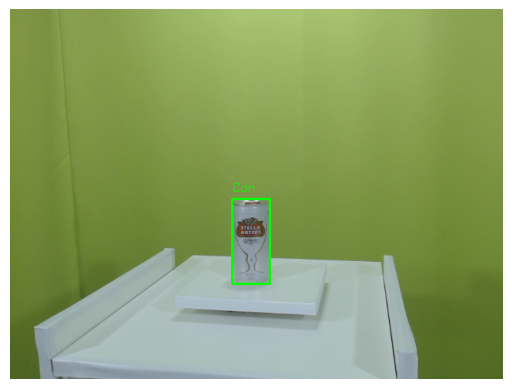

In [5]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

IMAGE = "Stella_right_1.png"

model = YOLO("yolov8n.pt")
results = model(IMAGE)

# Extract bounding boxes in pixel coordinates
pixel_bboxes = []
for result in results:
    for box in result.boxes.xyxy:
        pixel_bboxes.append([int(box[0]), int(box[1]), int(box[2]), int(box[3])])

# Load the image
image = cv2.imread(IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Annotate bounding boxes
for bbox in pixel_bboxes:
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green box for YOLO
    cv2.putText(image, f"Can", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Display the annotated image
plt.imshow(image)
plt.axis("off")
plt.show()

In [6]:
from ultralytics import YOLO, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE = "Stella_xtion_1.png"
model = YOLO("yolov8n.pt")
results = model(IMAGE)
sam = SAM("sam_b.pt")
for result in results:
    for box in result.boxes.xyxy:
        masks = sam(IMAGE, bboxes=box)
        print("Generated masks:", masks)
        # Overlay masks on the original image

        # Load the original image
        image = cv2.imread(IMAGE)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw the YOLO bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green box for YOLO
        cv2.putText(image, f"Class {int(cls_id)}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Save the image with the YOLO bounding box
        plt.imshow(image)
        plt.axis("off")
        plt.savefig("output_with_yolo_box.png")
        plt.show()

        # Iterate through the generated masks
        for mask in masks:
            mask_array = mask.masks.data.cpu().numpy()[0]  # Assuming single mask
            colored_mask = np.zeros_like(image, dtype=np.uint8)
            colored_mask[mask_array > 0] = [255, 0, 0]  # Red color for the mask

            # Blend the mask with the original image
            blended_image = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)

            # Save the blended image
            plt.imshow(blended_image)
            plt.axis("off")
            plt.savefig("output_with_mask.png")
            plt.show()



image 1/1 /home/gustavo/3d-template-matching/Stella_xtion_1.png: 480x640 1 traffic light, 66.7ms
Speed: 1.1ms preprocess, 66.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


KeyboardInterrupt: 


image 1/1 /home/gustavo/3d-template-matching/Stella_xtion_1.png: 1024x1024 1 0, 9381.0ms
Speed: 59.7ms preprocess, 9381.0ms inference, 5.4ms postprocess per image at shape (1, 3, 1024, 1024)
Generated masks: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: '0'}
obb: None
orig_img: array([[[217, 217, 217],
        [216, 216, 216],
        [216, 216, 216],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[217, 217, 217],
        [216, 216, 216],
        [216, 216, 216],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[217, 217, 217],
        [216, 216, 216],
        [216, 216, 216],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
 

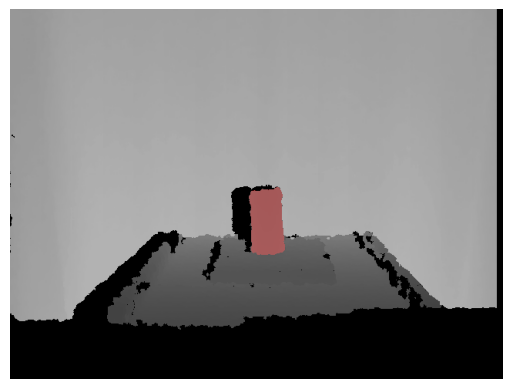

In [2]:
from ultralytics import YOLO, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE = "Stella_xtion_1.png"

# Load YOLO bounding boxes from IMAGE.txt
txt_file = IMAGE.rsplit(".", 1)[0] + ".txt"
bboxes = []
with open(txt_file, "r") as f:
    for line in f:
        cls_id, xc, yc, w, h = map(float, line.split())
        bboxes.append([xc, yc, w, h])

# Convert YOLO bounding boxes to pixel coordinates
img = cv2.imread(IMAGE)
H, W = img.shape[:2]
pixel_bboxes = []
for bbox in bboxes:
    xc, yc, w, h = bbox
    xmin = int((xc - w / 2) * W)
    xmax = int((xc + w / 2) * W)
    ymin = int((yc - h / 2) * H)
    ymax = int((yc + h / 2) * H)
    pixel_bboxes.append([xmin, ymin, xmax, ymax])

# Use the pixel_bboxes for further processing
model = YOLO("yolov8n.pt")
sam = SAM("sam_b.pt")
for box in pixel_bboxes:
    masks = sam(IMAGE, bboxes=box)
    print("Generated masks:", masks)
    # Overlay masks on the original image

    # Load the original image
    image = cv2.imread(IMAGE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Iterate through the generated masks
    for mask in masks:
        mask_array = mask.masks.data.cpu().numpy()[0]  # Assuming single mask
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        colored_mask[mask_array > 0] = [255, 0, 0]  # Red color for the mask

        # Blend the mask with the original image
        blended_image = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)

        # Save the blended image
        plt.imshow(blended_image)
        plt.axis("off")
        plt.savefig("output_with_mask.png")
        plt.show()


In [4]:
import open3d as o3d
import numpy as np

# 1. Load Point Cloud
pcd = o3d.io.read_point_cloud("Stella_xtion_1.pcd")
print(f"Loaded {len(pcd.points)} points")

# 2. Estimate Normals (Crucial for side-fitting)
# This helps the algorithm understand which way the surface curves.
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# 3. RANSAC Cylinder Fitting
# distance_threshold: max distance a point can be from the model to be considered an inlier
# radius_min/max: helps constrain the search if you know the approximate size
model, inliers = pcd.segment_cylinder(radius_min=0.01, 
                                      radius_max=1.0, 
                                      ransac_n=3, 
                                      distance_threshold=0.01, 
                                      iterations=1000)

# Unpack the model parameters
# The model returns [x, y, z, dx, dy, dz, radius]
# (x,y,z) is a point on the axis, (dx,dy,dz) is the axis vector
cx, cy, cz, dx, dy, dz, radius = model

print(f"\n=== CYLINDER FOUND ===")
print(f"Axis Point: [{cx:.4f}, {cy:.4f}, {cz:.4f}]")
print(f"Axis Vector: [{dx:.4f}, {dy:.4f}, {dz:.4f}]")
print(f"Radius: {radius:.4f}")

# 4. Visualization
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1, 0, 0]) # Red = Cylinder Patch

outlier_cloud = pcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0.5, 0.5, 0.5]) # Grey = Noise

# Optional: Draw the geometric cylinder shape to verify
mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=0.5)
mesh_cylinder.compute_vertex_normals()
mesh_cylinder.paint_uniform_color([0, 1, 0]) # Green = Perfect Model

# We need to transform the green cylinder to match the calculated pose
# (This requires a rotation matrix calculation similar to your 'build_pose' function)
# For now, we just visualize the points
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Loaded 243707 points


AttributeError: 'open3d.cpu.pybind.geometry.PointCloud' object has no attribute 'segment_cylinder'